# Libraries

In [98]:
from google.colab import drive
import pandas as pd

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
file_path = '/content/drive/My Drive/PEDAS 2024/dataTransaksi_PeDaS_2024_Train.csv'

df = pd.read_csv(file_path)

df.head()

,trx_code,trx_id,rek_code,rek,creationdate,type,amount,balance
0,50261,100085,1922,2526,2022-02-07 16:41:44+07:00,5,-100000.0,37.14
1,50260,100001,1922,2526,2022-02-07 16:02:58+07:00,5,-100000.0,100037.14
2,154447,775749,2346,9437,2022-03-07 08:53:06+07:00,5,-1000000.0,1679999.69
3,50285,564858,2346,9437,2022-03-03 18:41:16+07:00,1,100000.0,2609999.69
4,154240,565293,2212,5908,2022-03-03 20:22:31+07:00,1,100000.0,1200526.93


### List Rekening

In [102]:
unique_rek = df['rek'].unique()

unique_rek_list = unique_rek.tolist()

print(unique_rek_list)

[2526, 9437, 5908, 7665, 825, 7639, 13082, 13945, 1207, 8538, 6240, 6672, 6228, 9175, 8562, 11071, 2109, 541, 15414, 15169, 11745, 10694, 11920, 15442, 11284, 2864, 10957, 15923, 9210, 2673, 7977, 7354, 7638, 1734, 6376]


Extracts the unique values from the 'rek' column, which represents account numbers or identifiers. These unique values are stored in the unique_rek array, which is then converted into a list (unique_rek_list). Finally, it prints the list of unique account identifiers.

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16615 entries, 0 to 16614
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trx_code      16615 non-null  int64  
 1   trx_id        16615 non-null  int64  
 2   rek_code      16615 non-null  int64  
 3   rek           16615 non-null  int64  
 4   creationdate  16615 non-null  object 
 5   type          16615 non-null  int64  
 6   amount        16029 non-null  float64
 7   balance       16615 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 1.0+ MB


In [104]:
df['rek'].value_counts()

,count
rek,
2673,1693
15414,609
8562,573
13082,562
6228,553
9210,542
6240,511
15923,506
6672,492


In [105]:
len(df['rek'].value_counts())

35

The number of unique account identifiers (or 'rek') in the dataset is 35.

# Split accounts into separate series

In [106]:
rekening_list = [2526, 9437, 5908, 7665, 825, 7639, 13082, 13945, 1207, 8538,
                 6240, 6672, 6228, 9175, 8562, 11071, 2109, 541, 15414, 15169,
                 11745, 10694, 11920, 15442, 11284, 2864, 10957, 15923, 9210,
                 2673, 7977, 7354, 7638, 1734, 6376]

data_rekening = {}

for rek in rekening_list:
    data_filtered = df[df['rek'] == rek][['creationdate', 'balance']].copy()

    data_filtered['creationdate'] = pd.to_datetime(data_filtered['creationdate'], format='%Y-%m-%d %H:%M:%S%z')

    data_filtered.set_index('creationdate', inplace=True)

    data_filtered = data_filtered.sort_index()

    data_filtered = data_filtered[~data_filtered.index.duplicated(keep='last')]

    data_rekening[rek] = data_filtered

For each account, the code creates a separate time series containing the creationdate and balance data, removes duplicates, and stores each processed account's time series in a dictionary (data_rekening). This allows the account data to be handled separately, making it easier to analyze each account's transaction history individually.

In [107]:
data_rekening[2526].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2022-01-28 11:06:56+07:00 to 2024-10-21 17:37:07+07:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   balance  300 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


In [108]:
data_rekening[2526].head(10)

,balance
creationdate,
2022-01-28 11:06:56+07:00,200000.00
2022-02-01 00:15:31+07:00,200046.42
2022-02-07 16:02:58+07:00,100037.14
2022-02-07 16:41:44+07:00,37.14
2022-03-01 01:01:54+07:00,90.32
2022-03-12 10:54:44+07:00,2000090.32
2022-03-26 09:00:50+07:00,2500090.32
2022-04-01 00:02:36+07:00,2503374.93
2022-04-14 05:33:18+07:00,3502718.01


# Resample + Fill Missing Values

In [109]:
def round_time(data_dict):
    rounded_dict = {}
    for rek, data in data_dict.items():
        data_rounded = data.copy()
        data_rounded.index = data_rounded.index.round('h')
        rounded_dict[rek] = data_rounded
    return rounded_dict

data_rekening = round_time(data_rekening)

The code first defines a function `round_time` that rounds the timestamp index of each account's time series (in `data_dict`) to the nearest hour. It creates a new dictionary `rounded_dict` to store the rounded time series for each account (`rek`). The function then iterates over each account in `data_dict`, rounds the `creationdate` index to the nearest hour using the `round('h')` method, and stores the updated DataFrame in `rounded_dict`.

Afterwards, the code applies the `round_time` function to the `data_rekening` dictionary, resulting in the time series for each account being rounded to the nearest hour.

In [110]:
for rek, data in data_rekening.items():
    data_rekening[rek] = data[~data.index.duplicated(keep='last')]

For each account (`rek`), the code removes duplicate rows based on the index (`creationdate`) by keeping only the last occurrence (`~data.index.duplicated(keep='last')`). This ensures that any duplicate timestamps are removed, retaining the most recent entry for each timestamp.

The overall goal is to ensure that each account's time series is properly aligned to hourly intervals and that there are no duplicate timestamps in the data.

In [111]:
data_rekening[2526].head(10)

,balance
creationdate,
2022-01-28 11:00:00+07:00,200000.00
2022-02-01 00:00:00+07:00,200046.42
2022-02-07 16:00:00+07:00,100037.14
2022-02-07 17:00:00+07:00,37.14
2022-03-01 01:00:00+07:00,90.32
2022-03-12 11:00:00+07:00,2000090.32
2022-03-26 09:00:00+07:00,2500090.32
2022-04-01 00:00:00+07:00,2503374.93
2022-04-14 06:00:00+07:00,3502718.01


In [112]:
for rek, data in data_rekening.items():
    data = data.resample('h').asfreq()

    data['balance'] = data['balance'].interpolate(method='time')

    data_rekening[rek] = data

Resamples the time series data for each account in `data_rekening` to hourly frequency (`'h'`) using the `resample('h')` method. This ensures that each account’s data is represented at a consistent hourly interval. For any missing time points, the `asfreq()` method ensures that gaps are introduced, setting those entries as NaN.

Then, for the `balance` column, the code uses linear interpolation (`interpolate(method='time')`) to fill in the missing values by estimating the values based on the time intervals. This helps ensure that the balance values are filled smoothly without abrupt jumps, making the data more continuous and usable for analysis.

Finally, the updated time series data for each account is saved back into the `data_rekening` dictionary, replacing the previous version of the data with the resampled and interpolated data.

In [113]:
data_rekening[6672].head(20)

,balance
creationdate,
2023-07-02 14:00:00+07:00,10800.000
2023-07-02 15:00:00+07:00,11520.000
2023-07-02 16:00:00+07:00,12240.000
2023-07-02 17:00:00+07:00,12960.000
2023-07-02 18:00:00+07:00,13680.000
2023-07-02 19:00:00+07:00,14400.000
2023-07-02 20:00:00+07:00,15120.000
2023-07-02 21:00:00+07:00,15840.000
2023-07-02 22:00:00+07:00,16560.000


# Read Data Test (Inference)

In [114]:
file_path = '/content/drive/My Drive/PEDAS 2024/dataTransaksi_PeDaS_2024_Test_Peserta.csv'

df_test = pd.read_csv(file_path)

df_test.head(35)

,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,NaN
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,NaN
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,NaN
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,NaN
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,NaN
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,NaN
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,NaN
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,NaN
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,NaN
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,NaN


In [115]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trx_code      35 non-null     int64  
 1   trx_id        35 non-null     int64  
 2   rek_code      35 non-null     int64  
 3   rek           35 non-null     int64  
 4   creationdate  35 non-null     object 
 5   type          0 non-null      float64
 6   balance       0 non-null      float64
dtypes: float64(2), int64(4), object(1)
memory usage: 2.0+ KB


# Training & Evaluate + Inference

In [ ]:
def prepare_data(data):
    """
    Menambahkan fitur waktu dan lag pada data.
    """
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['lag1'] = data['balance'].shift(1)
    data['lag2'] = data['balance'].shift(2)
    data['lag3'] = data['balance'].shift(3)
    data = data.dropna()
    return data

The `prepare_data` function adds time-related features (`hour`, `dayofweek`, `month`, `year`) to the data, and creates lag features (`lag1`, `lag2`, `lag3`) for the `balance` column by shifting the values by 1, 2, and 3 time steps. It then removes any rows with missing values (`NaN`).

In [ ]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def train_and_evaluate(rekening, data_rekening, model, trained_models):
    """
    Melatih model pada rekening tertentu dan melakukan evaluasi.
    Model disimpan dalam dictionary `trained_models` dengan key rekening.
    """
    data = data_rekening[rekening].copy()

    data_prepared = prepare_data(data)

    X = data_prepared[['hour', 'dayofweek', 'month', 'year', 'lag1', 'lag2', 'lag3']]
    y = data_prepared['balance']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_score = smape(y_test, y_pred)

    print(f"Evaluation Metrics for Rekening {rekening}:")
    print(f"SMAPE: {smape_score:.2f}%")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--', alpha=0.7)
    plt.title(f'Actual vs Predicted Balance (Rekening {rekening})')
    plt.xlabel('Time')
    plt.ylabel('Balance')
    plt.legend()
    plt.grid(True)
    plt.show()

    trained_models[rekening] = model

    return model

The `train_and_evaluate` function trains a model on a specific account's data, evaluates its performance using metrics like SMAPE, MAE, and RMSE, and plots the actual vs. predicted balance over time. It then saves the trained model for the account in the `trained_models` dictionary.

In [117]:
def inference(rekening, df_test, trained_models):
    """
    Melakukan inference untuk rekening tertentu menggunakan model yang sudah dilatih.
    Mengganti nilai NaN pada kolom 'balance' dengan hasil prediksi.
    """
    if rekening not in trained_models:
        print(f"Model untuk rekening {rekening} belum dilatih!")
        return None

    df_test_rekening = df_test[df_test['rek'] == rekening].copy()

    df_test_rekening['creationdate'] = pd.to_datetime(df_test_rekening['creationdate'], format='%Y-%m-%d %H:%M:%S%z')

    df_test_rekening['hour'] = df_test_rekening['creationdate'].dt.hour
    df_test_rekening['dayofweek'] = df_test_rekening['creationdate'].dt.dayofweek
    df_test_rekening['month'] = df_test_rekening['creationdate'].dt.month
    df_test_rekening['year'] = df_test_rekening['creationdate'].dt.year

    last_training_data = data_rekening[rekening].iloc[-3:]['balance'].values
    df_test_rekening['lag1'] = last_training_data[-1]
    df_test_rekening['lag2'] = last_training_data[-2]
    df_test_rekening['lag3'] = last_training_data[-3]

    X_test = df_test_rekening[['hour', 'dayofweek', 'month', 'year', 'lag1', 'lag2', 'lag3']]

    model = trained_models[rekening]
    y_pred = model.predict(X_test)

    df_test.loc[df_test['rek'] == rekening, 'balance'] = y_pred

    print(f"Inference selesai untuk rekening {rekening}")
    return df_test[df_test['rek'] == rekening]

The `inference` function performs predictions for a specific account using a previously trained model. It prepares the test data by extracting time-related features and adding lag values based on the last three balances. It then uses the trained model to predict the balance, replacing the NaN values in the `'balance'` column with the predicted values. The function returns the updated test data for the specified account.

# Training Model and Inference for each Rekening

### 2526

Evaluation Metrics for Rekening 2526:
SMAPE: 0.27%
MAE: 2977.97
RMSE: 7399.39


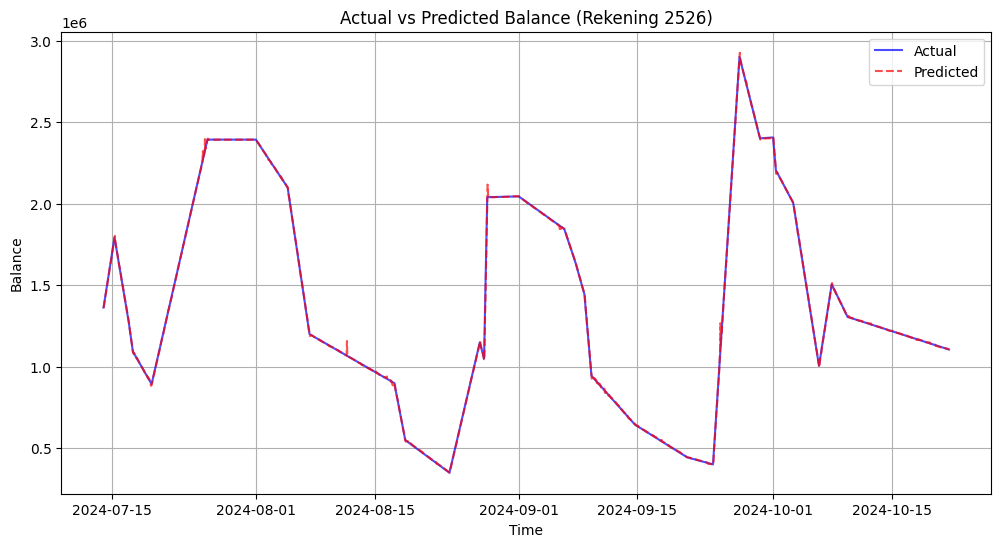

Inference selesai untuk rekening 2526


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,NaN
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,NaN
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,NaN
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,NaN


In [118]:
rekening = 2526

model_2526 = RandomForestRegressor(max_depth=20, n_estimators=200)

trained_model_2526 = train_and_evaluate(rekening, data_rekening, model_2526, trained_models)

inference_result_2526 = inference(rekening, df_test, trained_models)

df_test.head()

### 9437

Evaluation Metrics for Rekening 9437:
SMAPE: 3.63%
MAE: 6495.09
RMSE: 27388.15


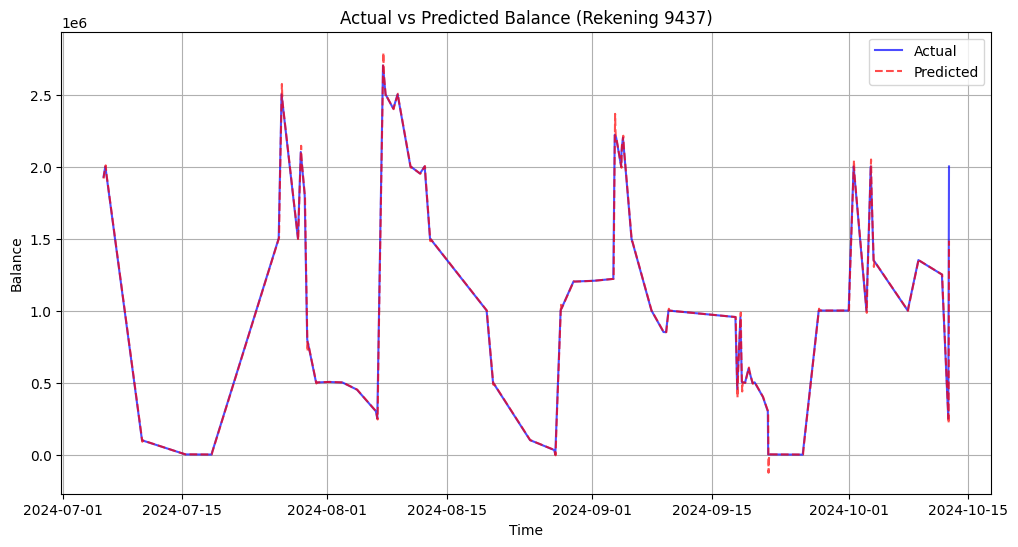

Inference selesai untuk rekening 9437


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,NaN
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,NaN
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,NaN


In [119]:
rekening = 9437

model_9437 = LinearRegression(fit_intercept=False)

trained_model_9437 = train_and_evaluate(rekening, data_rekening, model_9437, trained_models)

inference_result_9437 = inference(rekening, df_test, trained_models)

df_test.head()

### 5908

Evaluation Metrics for Rekening 5908:
SMAPE: 6.71%
MAE: 20796.53
RMSE: 76791.54


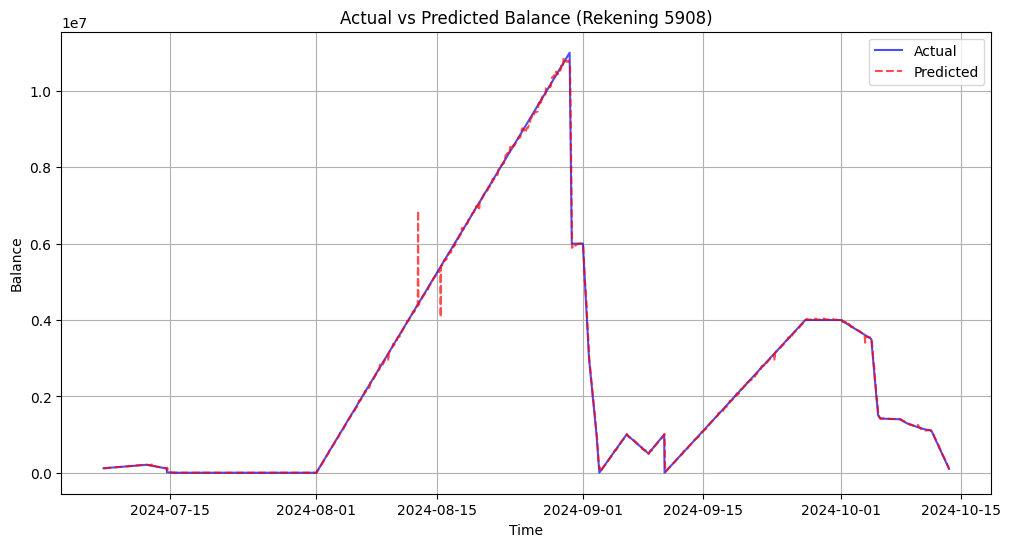

Inference selesai untuk rekening 5908


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,NaN
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,NaN


In [120]:
# Rekening yang ingin diproses
rekening = 5908

model_5908 = RandomForestRegressor(max_depth=20, n_estimators=200)

trained_model_5908 = train_and_evaluate(rekening, data_rekening, model_5908, trained_models)

inference_result_5908 = inference(rekening, df_test, trained_models)

df_test.head()

### 7665

Evaluation Metrics for Rekening 7665:
SMAPE: 0.07%
MAE: 1494.29
RMSE: 13234.22


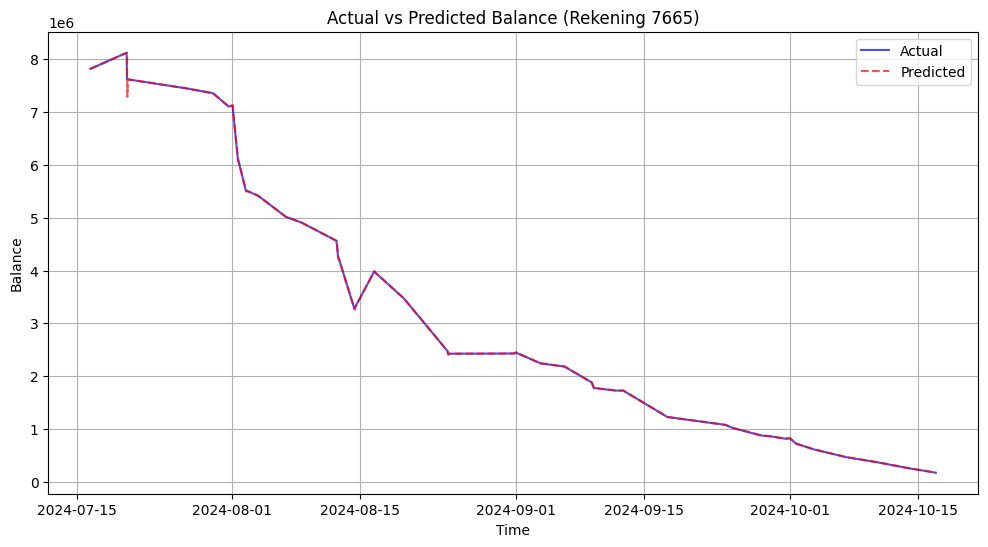

Inference selesai untuk rekening 7665


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,NaN


In [121]:
# Rekening yang ingin diproses
rekening = 7665

model_7665 = LinearRegression()

trained_model_7665 = train_and_evaluate(rekening, data_rekening, model_7665, trained_models)

inference_result_7665 = inference(rekening, df_test, trained_models)

df_test.head()

### 825

Evaluation Metrics for Rekening 825:
SMAPE: 4.05%
MAE: 9074.80
RMSE: 71790.39


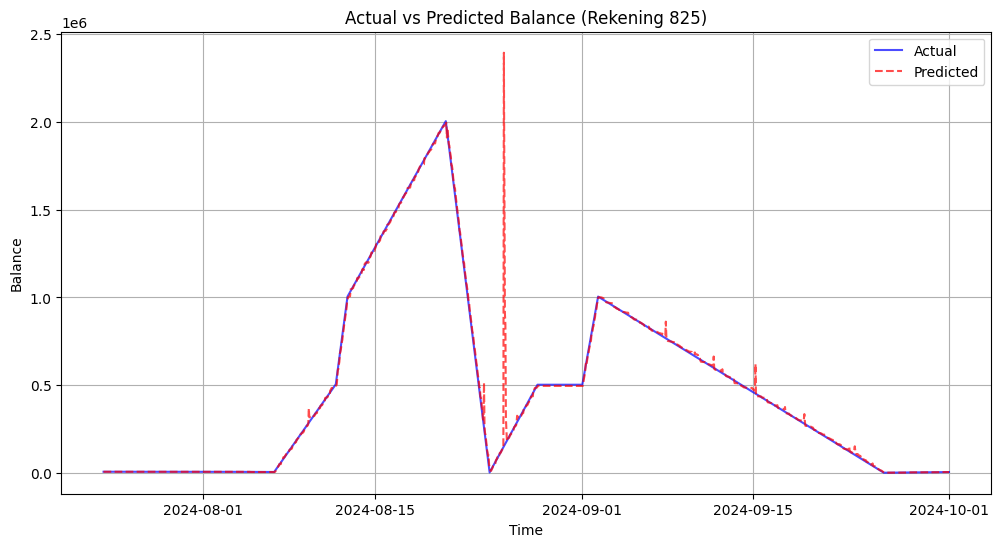

Inference selesai untuk rekening 825


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03


In [123]:
rekening = 825

model_825 = RandomForestRegressor(max_depth=10)

trained_model_825 = train_and_evaluate(rekening, data_rekening, model_825, trained_models)

inference_result_825 = inference(rekening, df_test, trained_models)

df_test.head()

### 7639

Evaluation Metrics for Rekening 7639:
SMAPE: 0.39%
MAE: 23485.93
RMSE: 150121.43


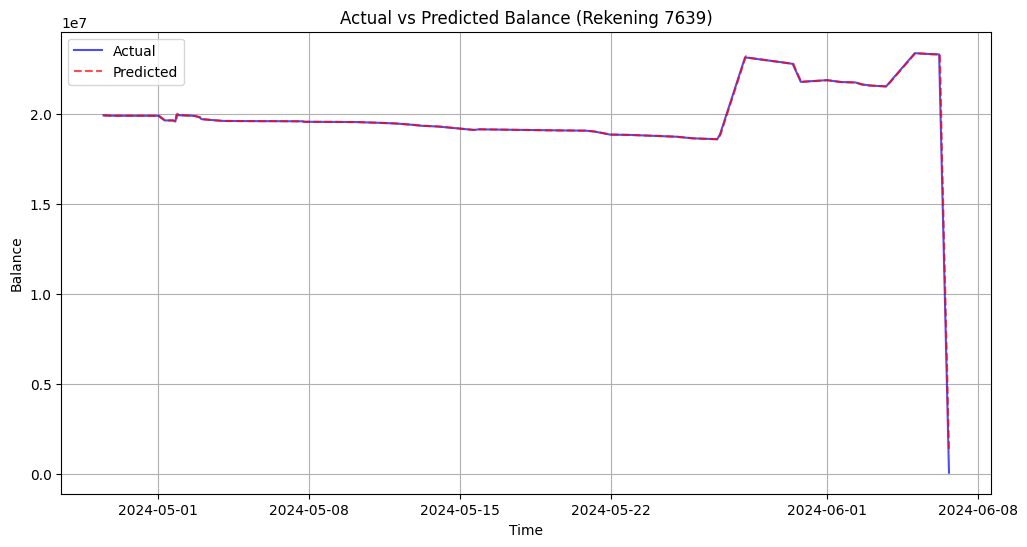

Inference selesai untuk rekening 7639


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,NaN
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,NaN
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,NaN
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,NaN


In [124]:
rekening = 7639

model_7639 = LinearRegression()

trained_model_7639 = train_and_evaluate(rekening, data_rekening, model_7639, trained_models)

inference_result_7639 = inference(rekening, df_test, trained_models)

df_test.head(10)

### 13082

Evaluation Metrics for Rekening 13082:
SMAPE: 11.37%
MAE: 4659.00
RMSE: 36706.65


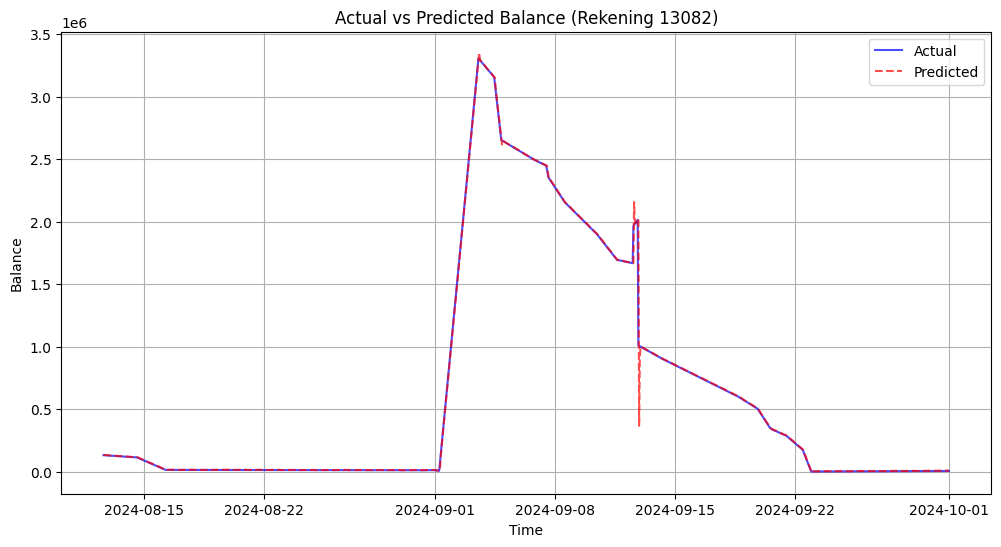

Inference selesai untuk rekening 13082


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,NaN
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,NaN
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,NaN


In [125]:
rekening = 13082

model_13082 = LinearRegression(fit_intercept=False)

trained_model_13082 = train_and_evaluate(rekening, data_rekening, model_13082, trained_models)

inference_result_13082 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 13945

Evaluation Metrics for Rekening 13945:
SMAPE: 1.18%
MAE: 53651.99
RMSE: 753394.70


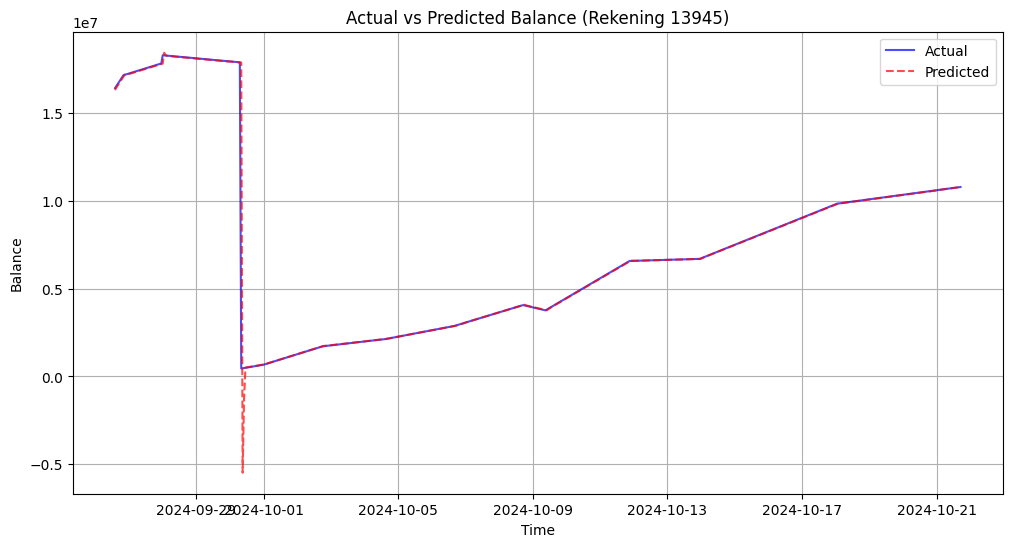

Inference selesai untuk rekening 13945


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,NaN
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,NaN


In [126]:
rekening = 13945

model_13945 = LinearRegression()

trained_model_13945 = train_and_evaluate(rekening, data_rekening, model_13945, trained_models)

inference_result_13945 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 1207

Evaluation Metrics for Rekening 1207:
SMAPE: 0.06%
MAE: 13148.46
RMSE: 39612.44


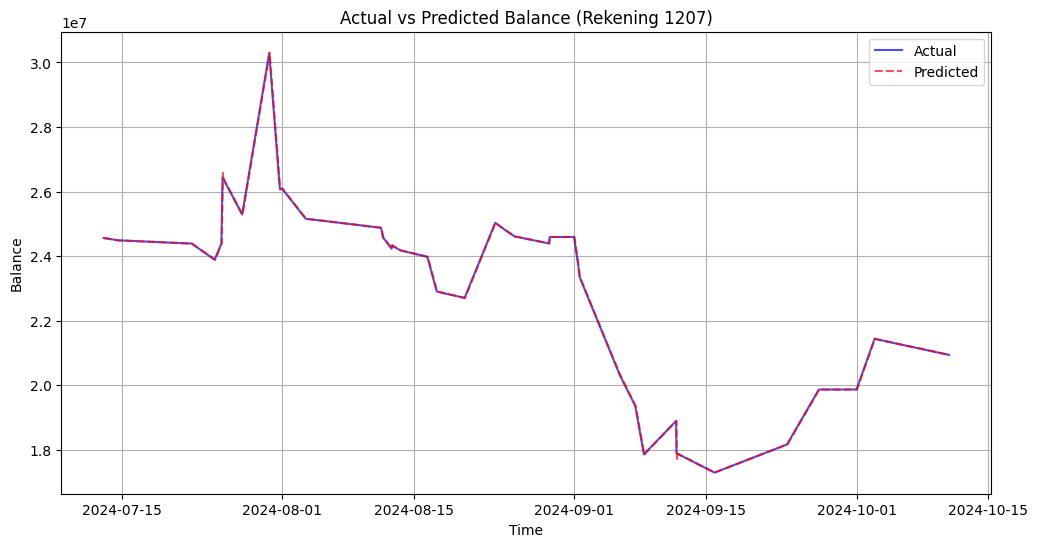

Inference selesai untuk rekening 1207


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,NaN


In [127]:
rekening = 1207

model_1207 = LinearRegression()

trained_model_1207 = train_and_evaluate(rekening, data_rekening, model_1207, trained_models)

inference_result_1207 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 8538

Evaluation Metrics for Rekening 8538:
SMAPE: 7.16%
MAE: 7235.97
RMSE: 20146.30


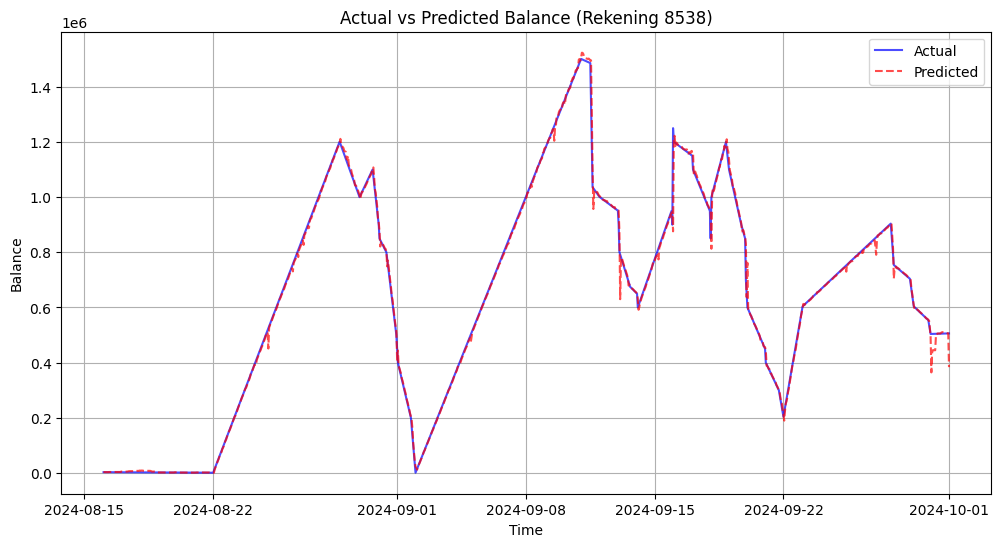

Inference selesai untuk rekening 8538


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [129]:
rekening = 8538

model_8538 = RandomForestRegressor(max_depth=20)

trained_model_8538 = train_and_evaluate(rekening, data_rekening, model_8538, trained_models)

inference_result_8538 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 6240

Evaluation Metrics for Rekening 6240:
SMAPE: 0.84%
MAE: 3030.04
RMSE: 23516.13


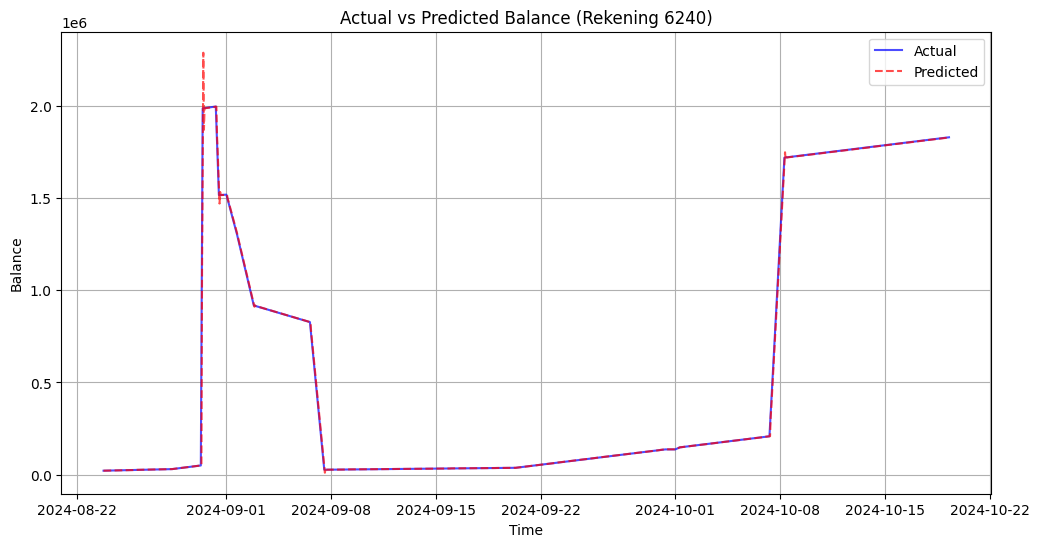

Inference selesai untuk rekening 6240


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [131]:
rekening = 6240

model_6240 = LinearRegression(fit_intercept=False)

trained_model_6240 = train_and_evaluate(rekening, data_rekening, model_6240, trained_models)

inference_result_6240 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 6672

Evaluation Metrics for Rekening 6672:
SMAPE: 0.45%
MAE: 349.66
RMSE: 2087.31


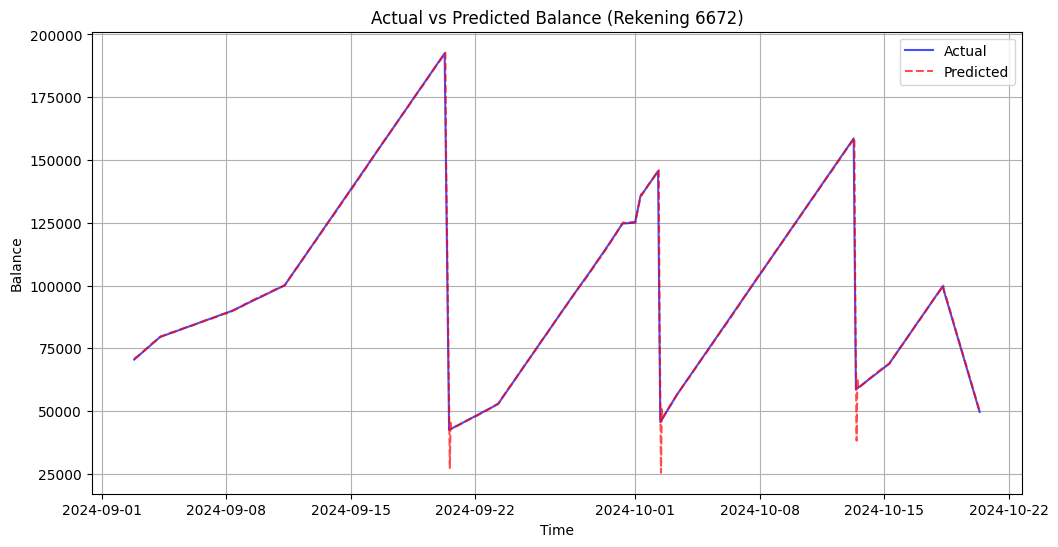

Inference selesai untuk rekening 6672


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [132]:
rekening = 6672

model_6672 = LinearRegression(fit_intercept=False)

trained_model_6672 = train_and_evaluate(rekening, data_rekening, model_6672, trained_models)

inference_result_6672 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 6228

Evaluation Metrics for Rekening 6228:
SMAPE: 0.44%
MAE: 7058.69
RMSE: 79124.39


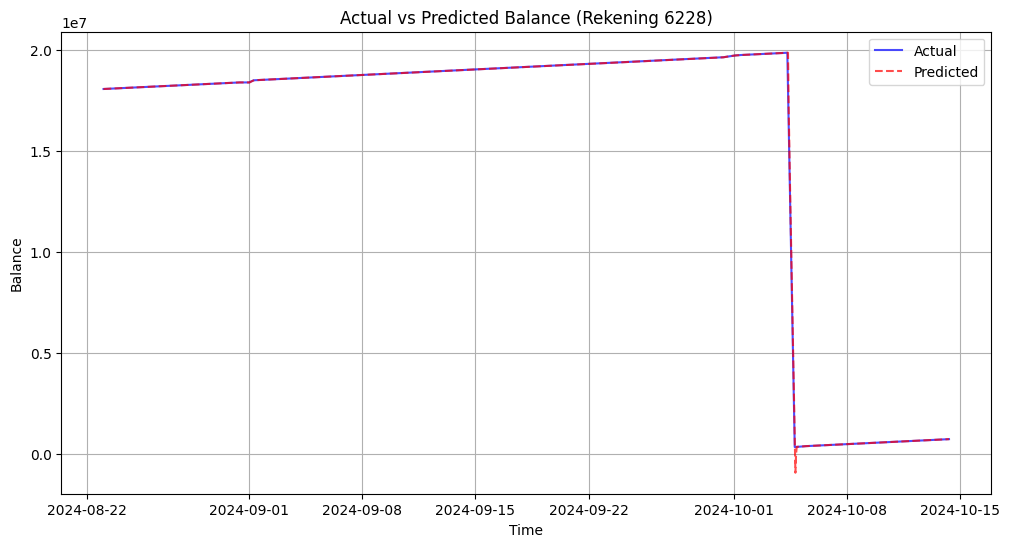

Inference selesai untuk rekening 6228


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [133]:
rekening = 6228

model_6228 = LinearRegression(fit_intercept=False)

trained_model_6228 = train_and_evaluate(rekening, data_rekening, model_6228, trained_models)

inference_result_6228 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 9175

Evaluation Metrics for Rekening 9175:
SMAPE: 0.53%
MAE: 820.65
RMSE: 1123.51


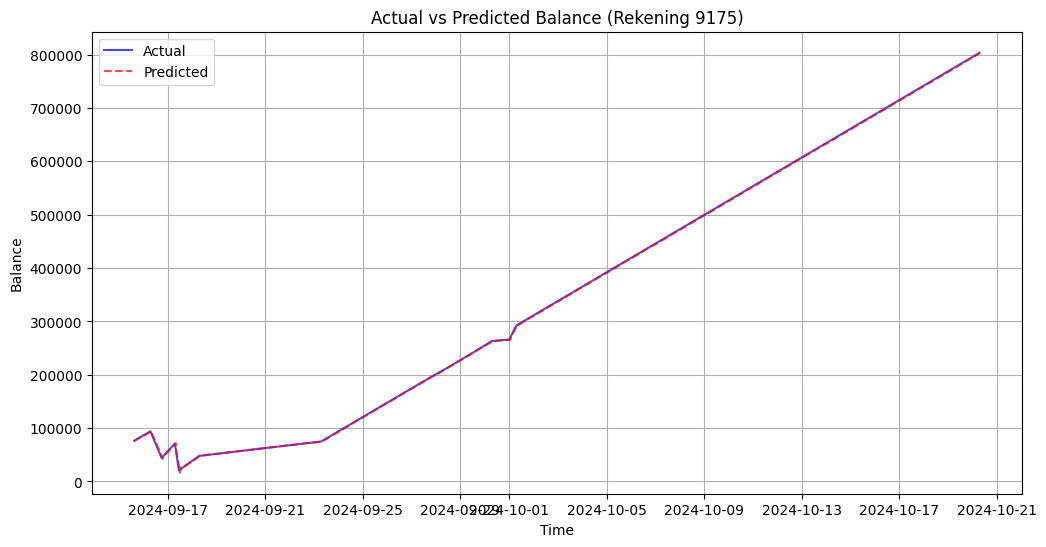

Inference selesai untuk rekening 9175


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [134]:
rekening = 9175

model_9175 = LinearRegression(fit_intercept=False)

trained_model_9175 = train_and_evaluate(rekening, data_rekening, model_9175, trained_models)

inference_result_9175 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 8562

Evaluation Metrics for Rekening 8562:
SMAPE: 0.29%
MAE: 6093.25
RMSE: 63678.48


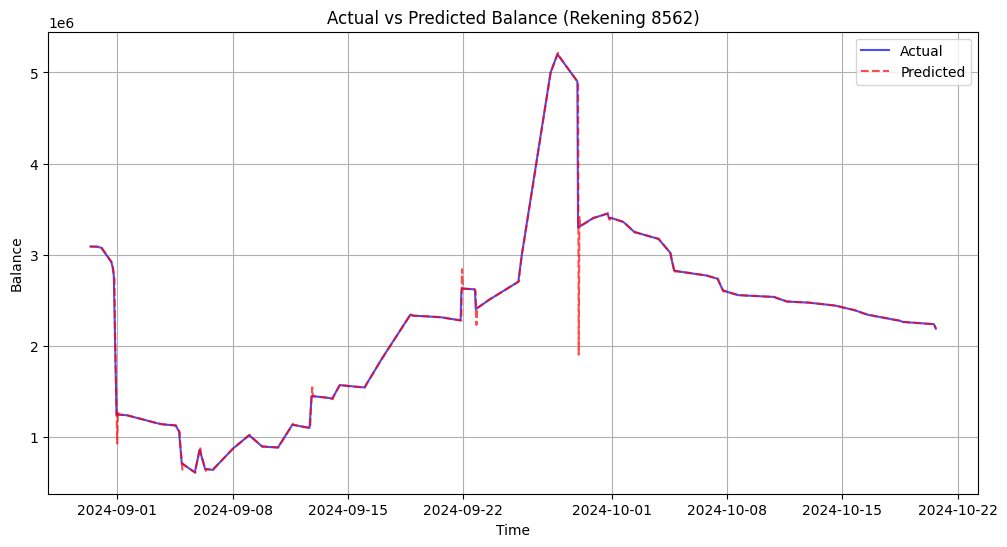

Inference selesai untuk rekening 8562


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [135]:
rekening = 8562

model_8562 = LinearRegression(fit_intercept=False)

trained_model_8562 = train_and_evaluate(rekening, data_rekening, model_8562, trained_models)

inference_result_8562 = inference(rekening, df_test, trained_models)

df_test.head(15)

### 11071

Evaluation Metrics for Rekening 11071:
SMAPE: 6.89%
MAE: 6391.31
RMSE: 14954.62


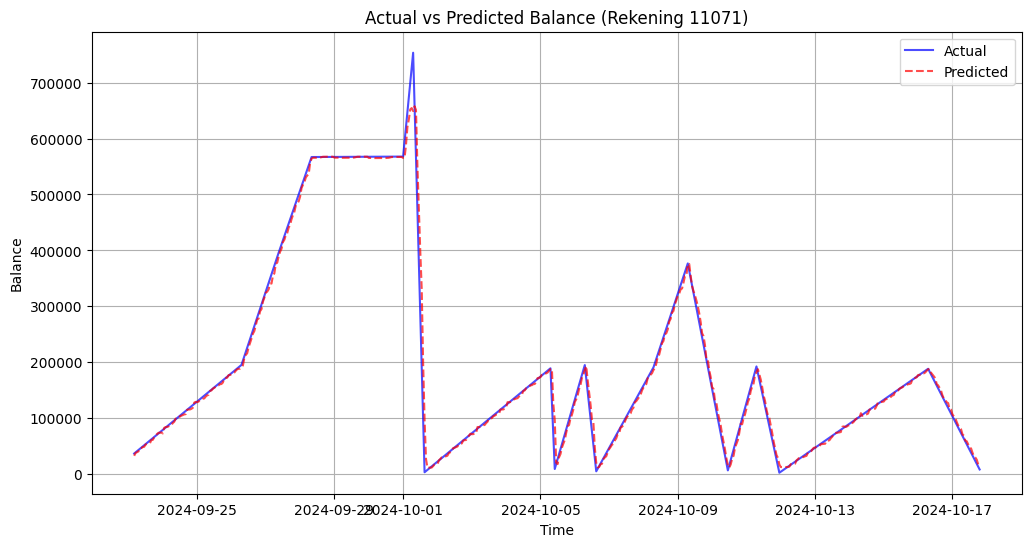

Inference selesai untuk rekening 11071


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [136]:
rekening = 11071

model_11071 = RandomForestRegressor(max_depth=10, n_estimators=200)

trained_model_11071 = train_and_evaluate(rekening, data_rekening, model_11071, trained_models)

inference_result_11071 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 2109

Evaluation Metrics for Rekening 2109:
SMAPE: 2.54%
MAE: 24710.45
RMSE: 90462.83


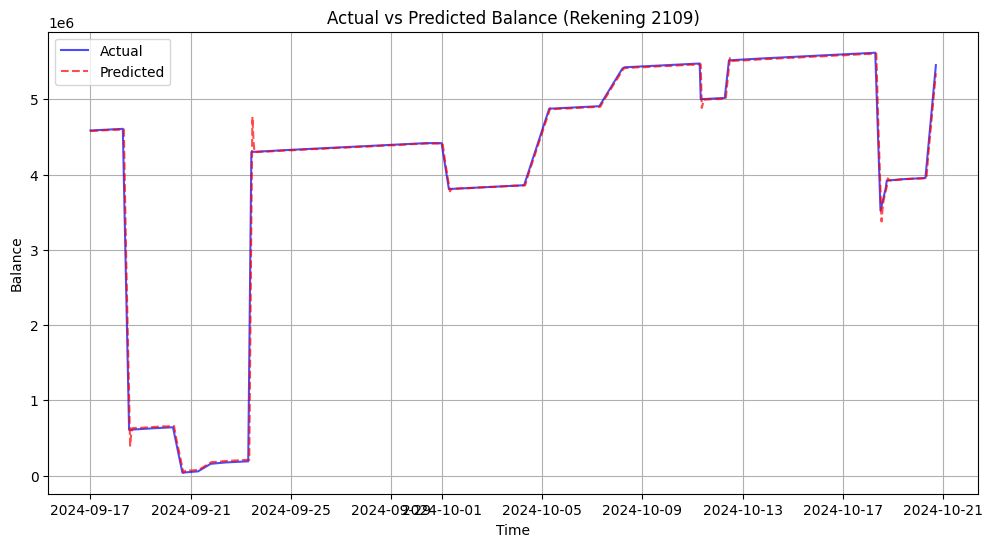

Inference selesai untuk rekening 2109


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [137]:
rekening = 2109

model_2109 = LinearRegression()

trained_model_2109 = train_and_evaluate(rekening, data_rekening, model_2109, trained_models)

inference_result_2109 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 541

Evaluation Metrics for Rekening 541:
SMAPE: 0.06%
MAE: 2965.16
RMSE: 3032.68


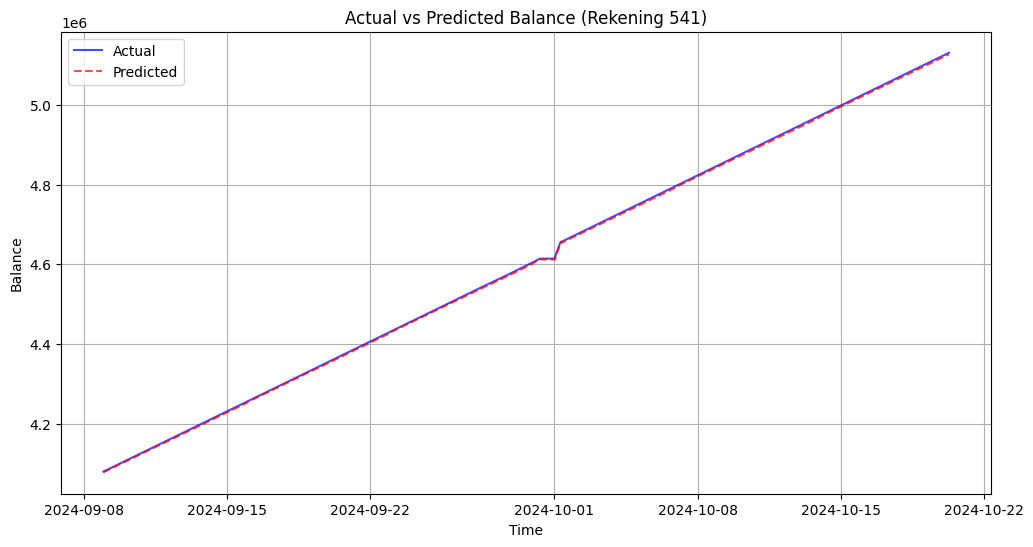

Inference selesai untuk rekening 541


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [140]:
rekening = 541

model_541 = LinearRegression(fit_intercept=False)

trained_model_541 = train_and_evaluate(rekening, data_rekening, model_541, trained_models)

inference_result_541 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 15414

Evaluation Metrics for Rekening 15414:
SMAPE: 0.69%
MAE: 4494.89
RMSE: 44973.95


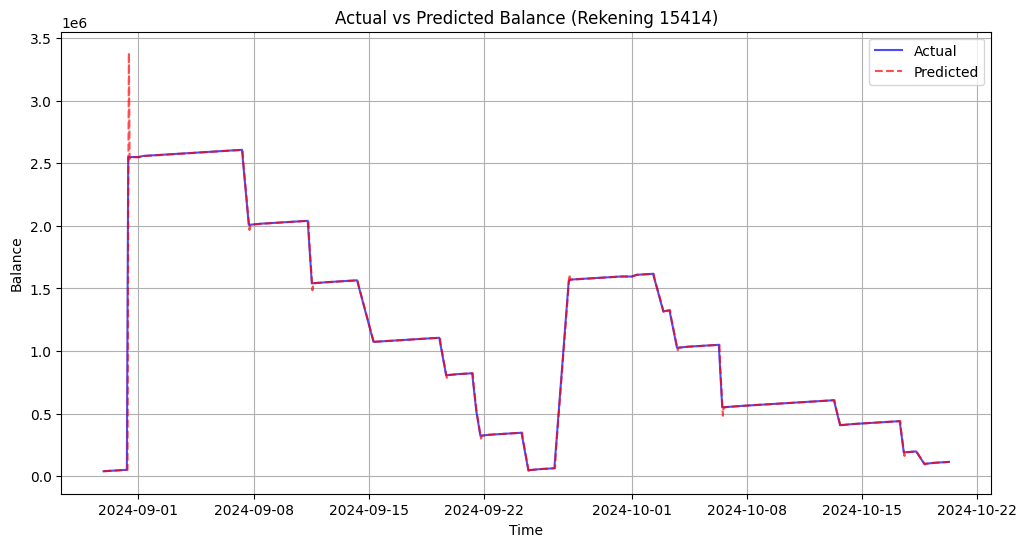

Inference selesai untuk rekening 15414


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [141]:
rekening = 15414

model_15414 = LinearRegression(fit_intercept=False)

trained_model_15414 = train_and_evaluate(rekening, data_rekening, model_15414, trained_models)

inference_result_15414 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 15169

Evaluation Metrics for Rekening 15169:
SMAPE: 0.23%
MAE: 8045.67
RMSE: 20149.56


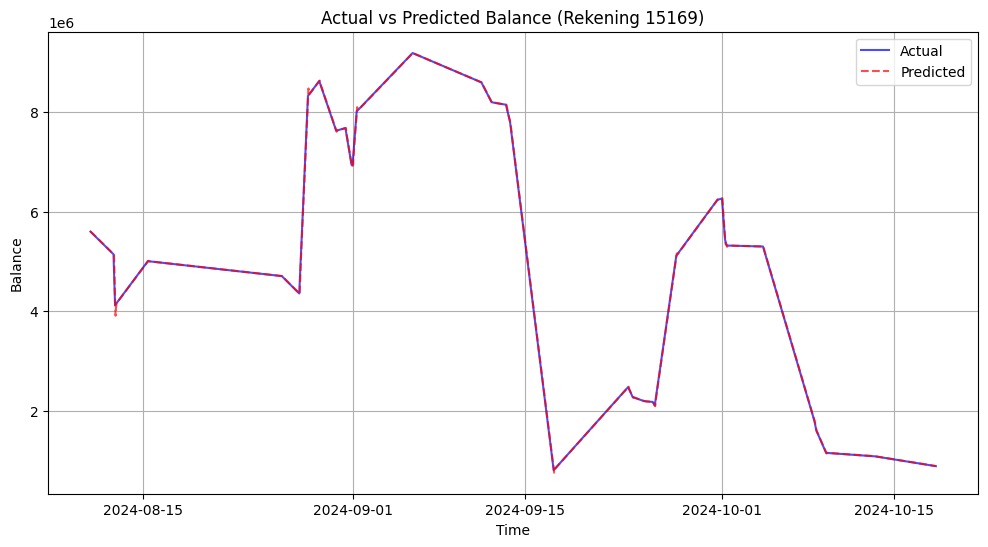

Inference selesai untuk rekening 15169


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [142]:
rekening = 15169

model_15169 = LinearRegression(fit_intercept=False)

trained_model_15169 = train_and_evaluate(rekening, data_rekening, model_15169, trained_models)

inference_result_15169 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 11745

Evaluation Metrics for Rekening 11745:
SMAPE: 0.76%
MAE: 235.91
RMSE: 1386.10


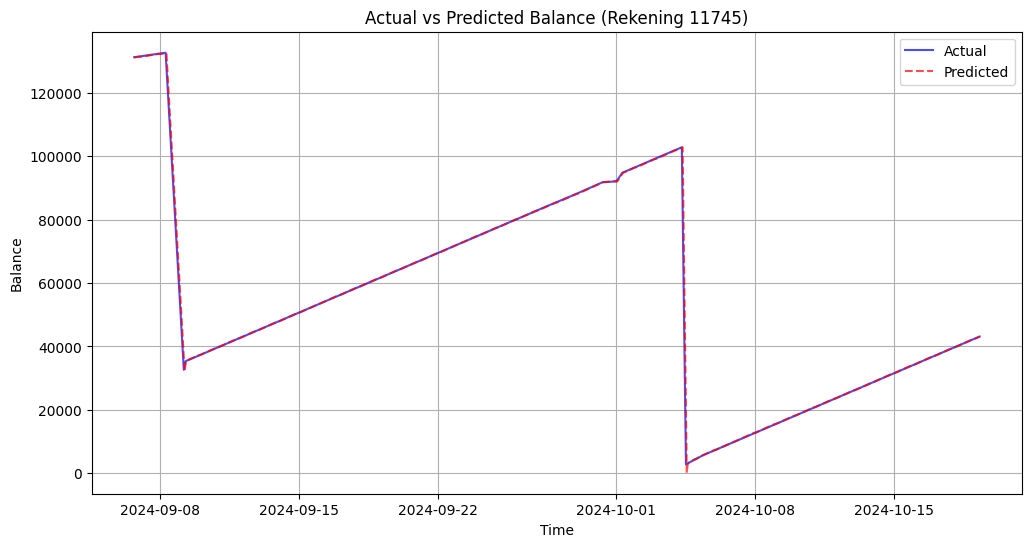

Inference selesai untuk rekening 11745


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [143]:
rekening = 11745

model_11745 = LinearRegression(fit_intercept=False)

trained_model_11745 = train_and_evaluate(rekening, data_rekening, model_11745, trained_models)

inference_result_11745 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 10694

Evaluation Metrics for Rekening 10694:
SMAPE: 0.00%
MAE: 43.56
RMSE: 305.78


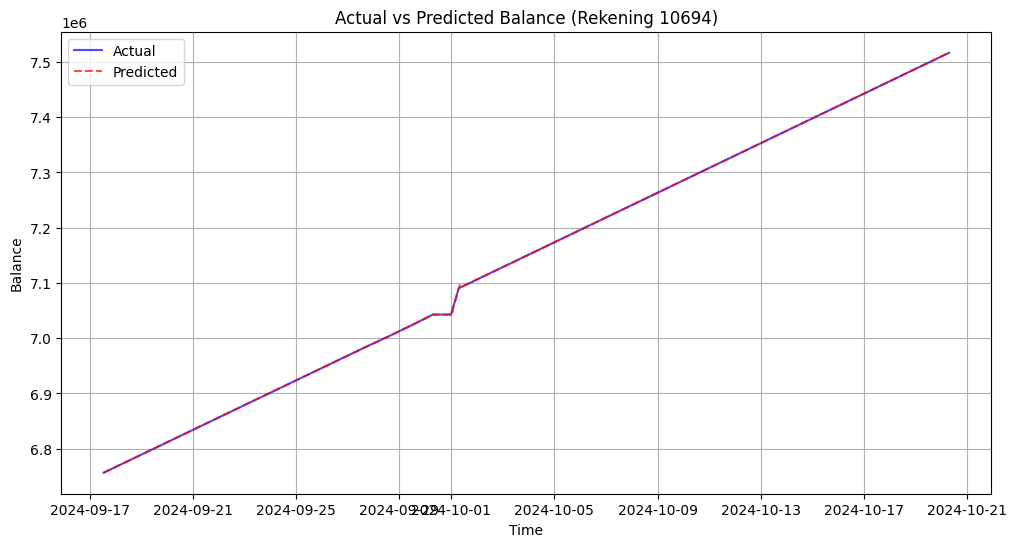

Inference selesai untuk rekening 10694


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [144]:
rekening = 10694

model_10694 = LinearRegression()

trained_model_10694 = train_and_evaluate(rekening, data_rekening, model_10694, trained_models)

inference_result_10694 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 11920

Evaluation Metrics for Rekening 11920:
SMAPE: 0.17%
MAE: 3551.24
RMSE: 7706.50


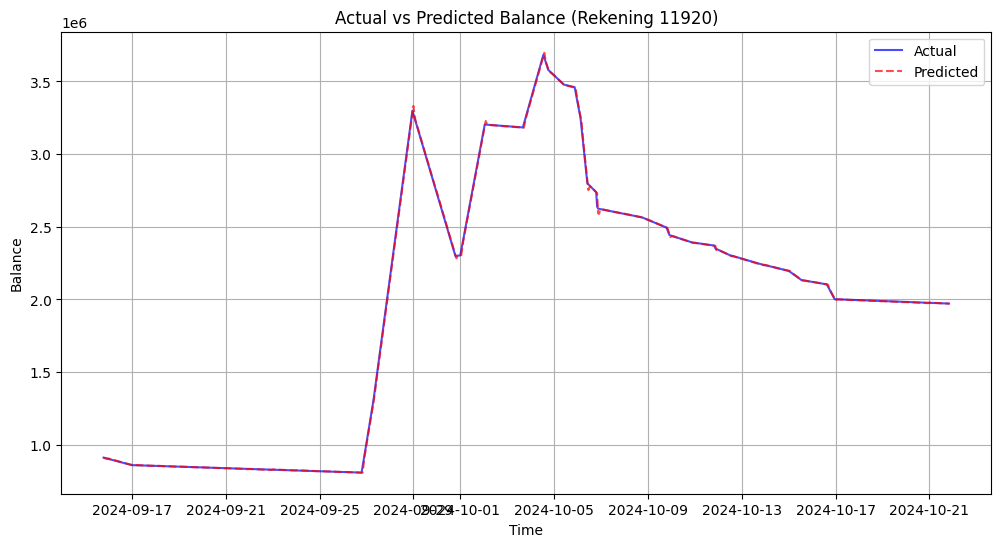

Inference selesai untuk rekening 11920


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [145]:
rekening = 11920

model_11920 = LinearRegression(fit_intercept=False)

trained_model_11920 = train_and_evaluate(rekening, data_rekening, model_11920, trained_models)

inference_result_11920 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 15442

Evaluation Metrics for Rekening 15442:
SMAPE: 0.02%
MAE: 14179.17
RMSE: 42510.75


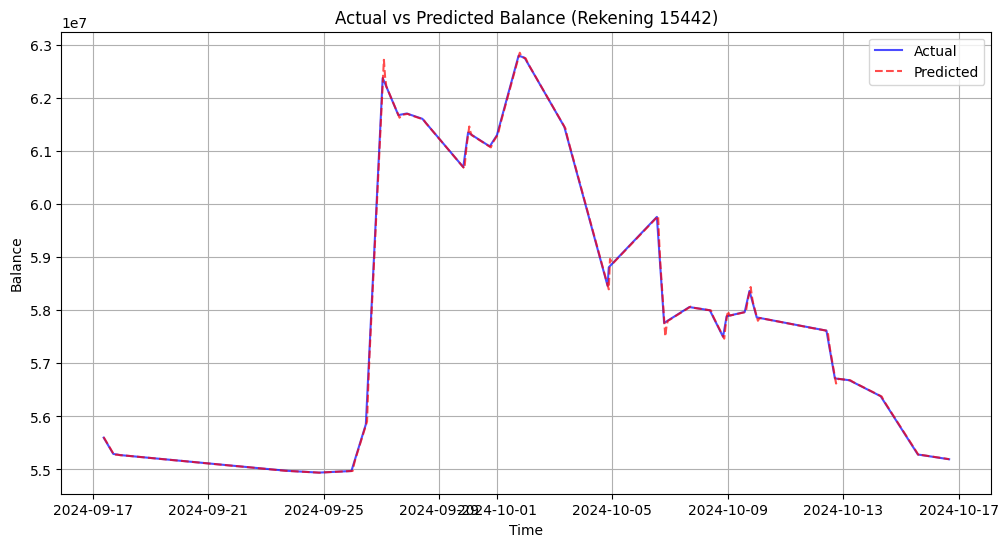

Inference selesai untuk rekening 15442


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [146]:
rekening = 15442

model_15442 = LinearRegression()

trained_model_15442 = train_and_evaluate(rekening, data_rekening, model_15442, trained_models)

inference_result_15442 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 11284

Evaluation Metrics for Rekening 11284:
SMAPE: 0.05%
MAE: 1531.50
RMSE: 7587.64


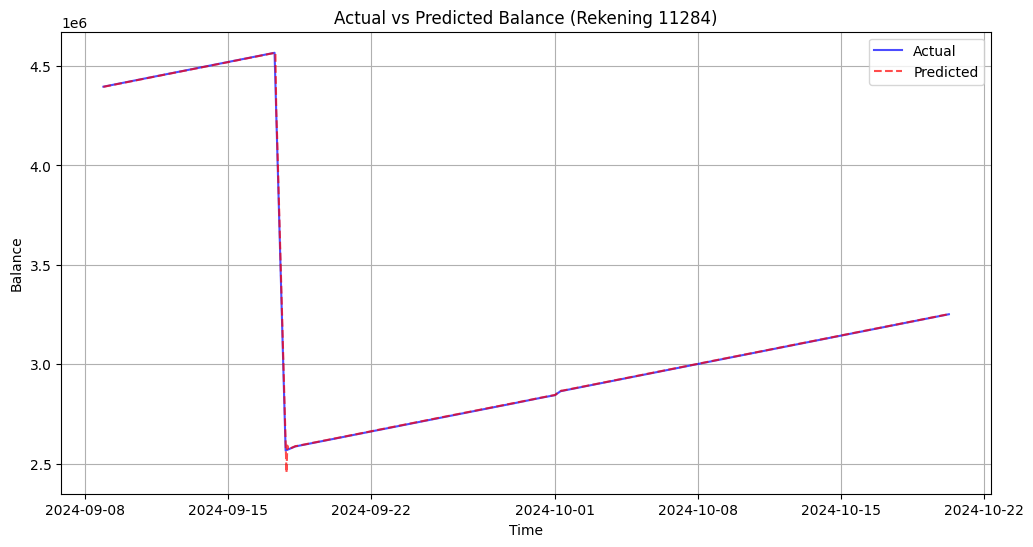

Inference selesai untuk rekening 11284


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [147]:
rekening = 11284

model_11284 = LinearRegression()

trained_model_11284 = train_and_evaluate(rekening, data_rekening, model_11284, trained_models)

inference_result_11284 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 2864

Evaluation Metrics for Rekening 2864:
SMAPE: 0.00%
MAE: 549.74
RMSE: 1294.43


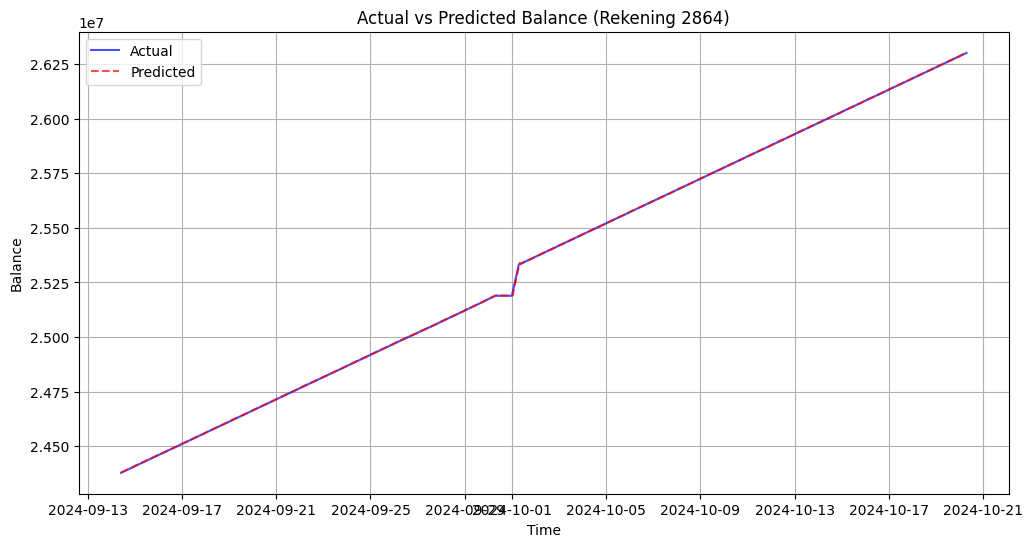

Inference selesai untuk rekening 2864


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [148]:
rekening = 2864

model_2864 = LinearRegression(fit_intercept=False)

trained_model_2864 = train_and_evaluate(rekening, data_rekening, model_2864, trained_models)

inference_result_2864 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 10957

Evaluation Metrics for Rekening 10957:
SMAPE: 0.15%
MAE: 550.15
RMSE: 3124.58


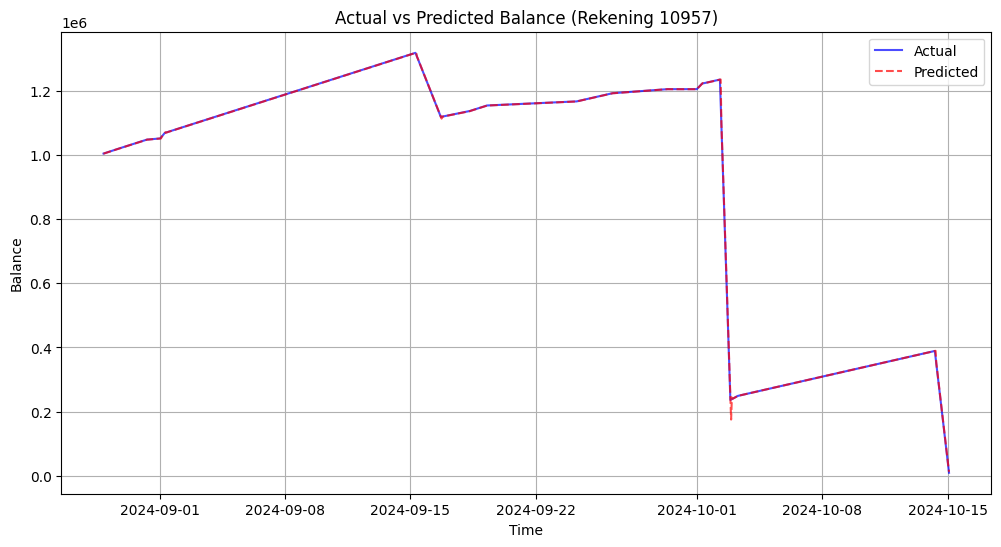

Inference selesai untuk rekening 10957


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [149]:
rekening = 10957

model_10957 = LinearRegression(fit_intercept=False)

trained_model_10957 = train_and_evaluate(rekening, data_rekening, model_10957, trained_models)

inference_result_10957 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 15923

Evaluation Metrics for Rekening 15923:
SMAPE: 0.26%
MAE: 16927.45
RMSE: 92785.61


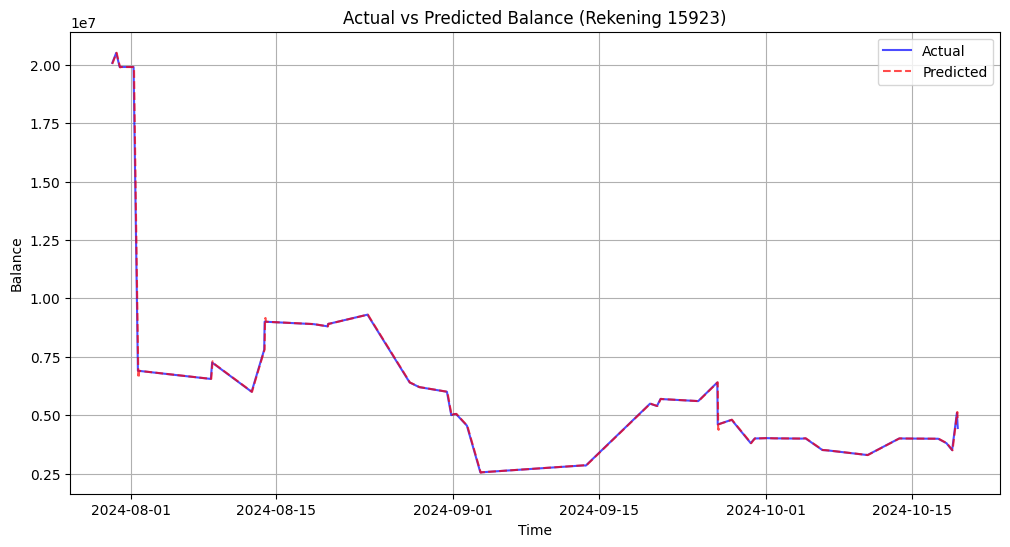

Inference selesai untuk rekening 15923


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [150]:
rekening = 15923

model_15923 = LinearRegression(fit_intercept=False)

trained_model_15923 = train_and_evaluate(rekening, data_rekening, model_15923, trained_models)

inference_result_15923 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 9210

Evaluation Metrics for Rekening 9210:
SMAPE: 0.04%
MAE: 5352.00
RMSE: 15247.07


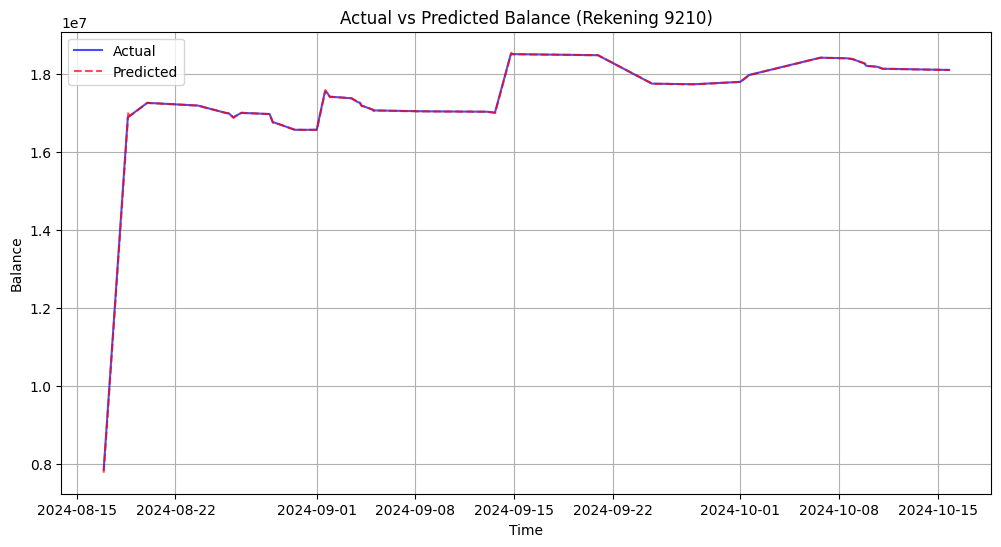

Inference selesai untuk rekening 9210


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [151]:
rekening = 9210

model_9210 = LinearRegression(fit_intercept=False)

trained_model_9210 = train_and_evaluate(rekening, data_rekening, model_9210, trained_models)

inference_result_9210 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 2673

Evaluation Metrics for Rekening 2673:
SMAPE: 32.01%
MAE: 536704.33
RMSE: 936818.85


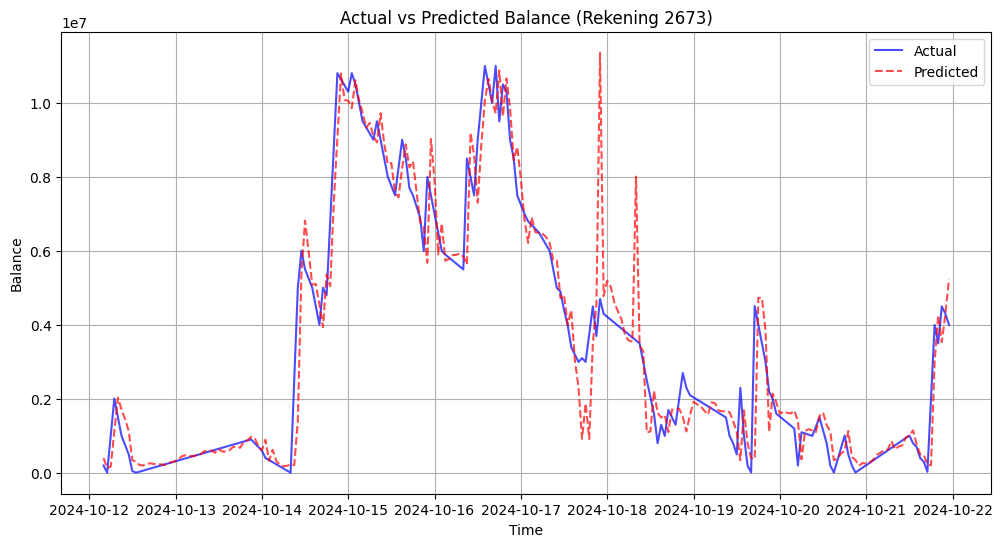

Inference selesai untuk rekening 2673


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [153]:
rekening = 2673

model_2673 = RandomForestRegressor(max_depth=20)

trained_model_2673 = train_and_evaluate(rekening, data_rekening, model_2673, trained_models)

inference_result_2673 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 7977

Evaluation Metrics for Rekening 7977:
SMAPE: 7.53%
MAE: 4247.15
RMSE: 15030.35


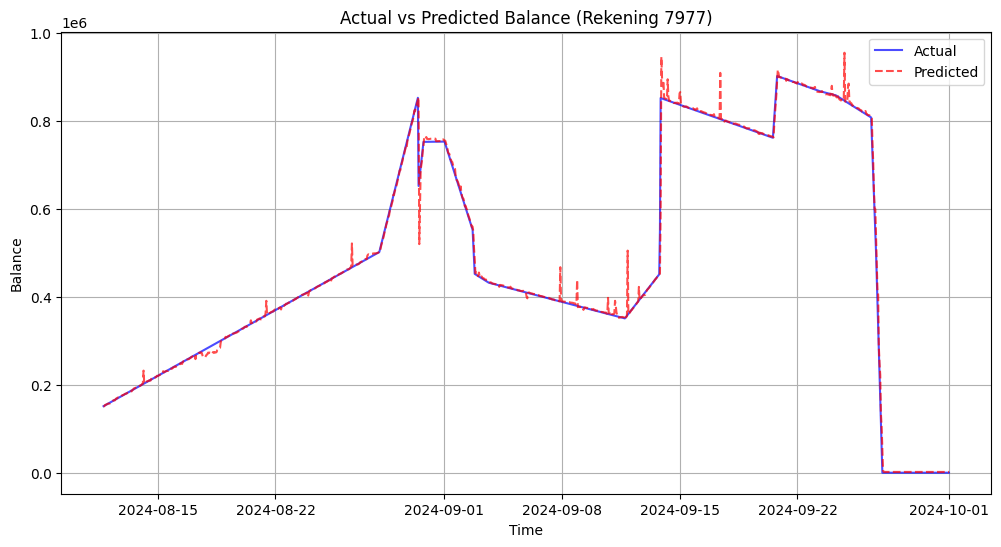

Inference selesai untuk rekening 7977


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [154]:
rekening = 7977

model_7977 = RandomForestRegressor(max_depth=20, n_estimators=200)

trained_model_7977 = train_and_evaluate(rekening, data_rekening, model_7977, trained_models)

inference_result_7977 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 7354

Evaluation Metrics for Rekening 7354:
SMAPE: 0.81%
MAE: 60.18
RMSE: 126.30


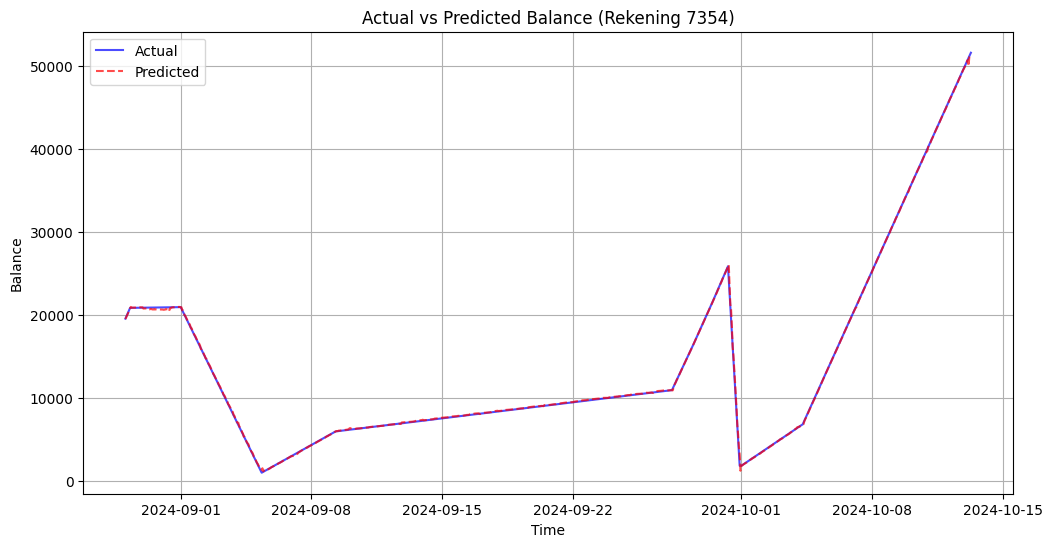

Inference selesai untuk rekening 7354


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [155]:
rekening = 7354

model_7354 = RandomForestRegressor(max_depth=20, n_estimators=200)

trained_model_7354 = train_and_evaluate(rekening, data_rekening, model_7354, trained_models)

inference_result_7354 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 7638

Evaluation Metrics for Rekening 7638:
SMAPE: 0.92%
MAE: 67.07
RMSE: 124.97


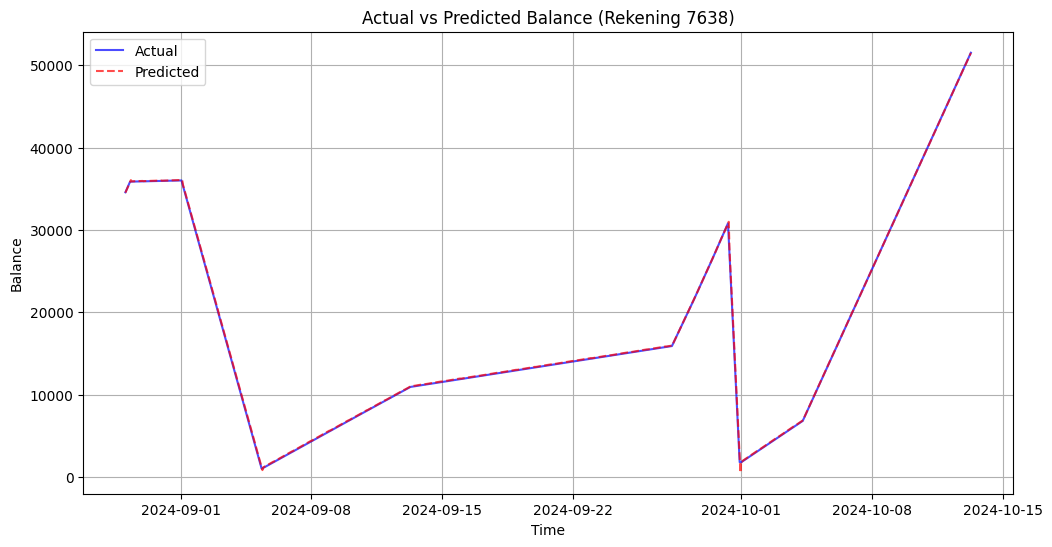

Inference selesai untuk rekening 7638


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [156]:
rekening = 7638

model_7638 = LinearRegression(fit_intercept=False)

trained_model_7638 = train_and_evaluate(rekening, data_rekening, model_7638, trained_models)

inference_result_7638 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 1734

Evaluation Metrics for Rekening 1734:
SMAPE: 1.32%
MAE: 1202.02
RMSE: 4821.07


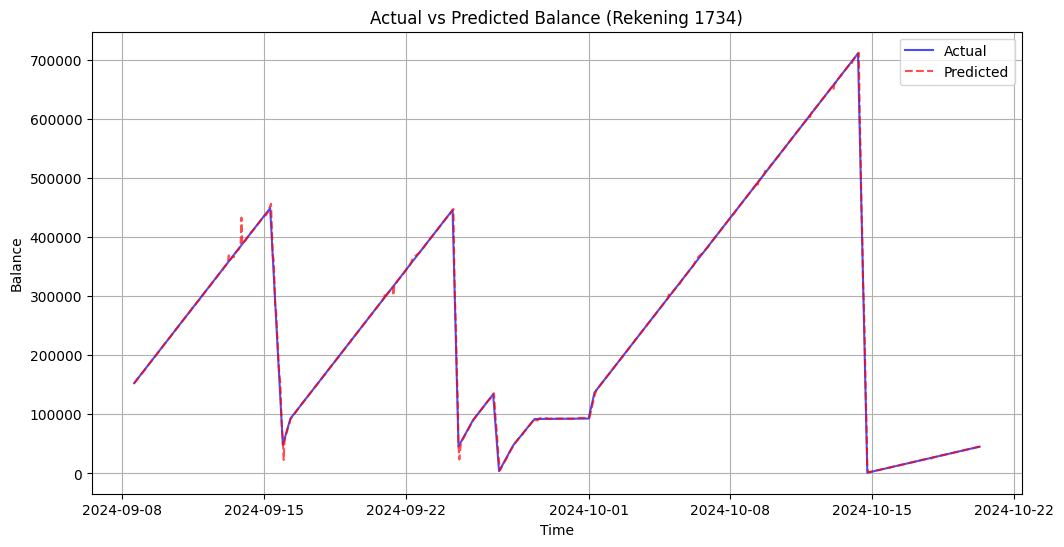

Inference selesai untuk rekening 1734


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [157]:
rekening = 1734

model_1734 = RandomForestRegressor(max_depth=20, n_estimators=200)

trained_model_1734 = train_and_evaluate(rekening, data_rekening, model_1734, trained_models)

inference_result_1734 = inference(rekening, df_test, trained_models)

df_test.head(35)

### 6376

Evaluation Metrics for Rekening 6376:
SMAPE: 1.20%
MAE: 17538.31
RMSE: 32610.38


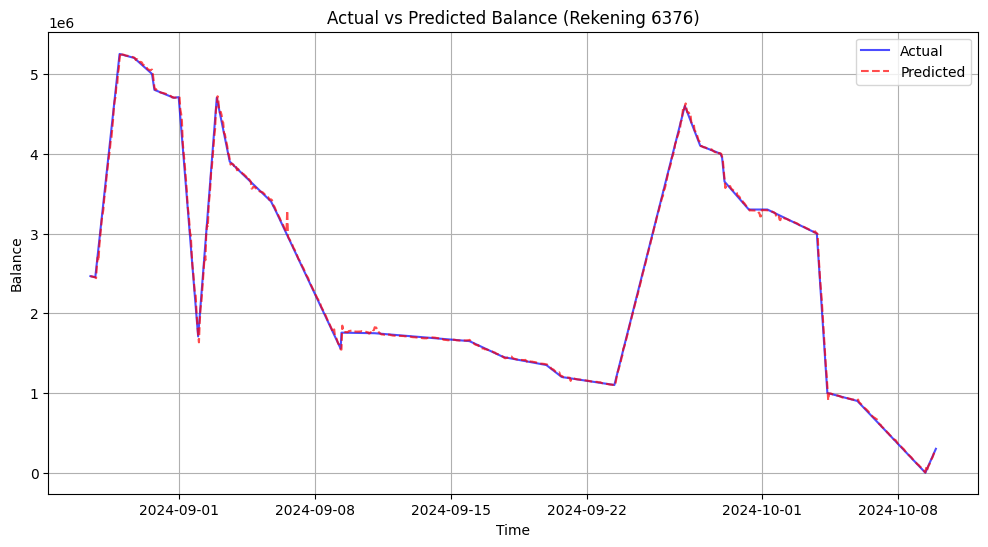

Inference selesai untuk rekening 6376


,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,-8.155700e+05
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


In [158]:
rekening = 6376

model_6376 = RandomForestRegressor(max_depth=20)

trained_model_6376 = train_and_evaluate(rekening, data_rekening, model_6376, trained_models)

inference_result_6376 = inference(rekening, df_test, trained_models)

df_test.head(35)

In [161]:
df_test_2 = df_test.copy()

In [162]:
df_test_2.loc[df_test_2['rek'] == 7639, 'balance'] = 0

In [163]:
df_test_2.head(35)

,trx_code,trx_id,rek_code,rek,creationdate,type,balance
0,233822,371848437,1922,2526,2024-10-21 20:02:14+07:00,NaN,1.105171e+06
1,281563,370918907,2346,9437,2024-10-17 08:23:41+07:00,NaN,2.511312e+06
2,310541,370287760,2212,5908,2024-10-14 07:44:47+07:00,NaN,9.663379e+04
3,37018,370872355,3799,7665,2024-10-16 23:04:24+07:00,NaN,1.713992e+05
4,142422,362772092,7868,825,2024-10-01 00:13:21+07:00,NaN,4.755267e+03
5,128215,312221200,11465,7639,2024-06-06 18:51:53+07:00,NaN,0.000000e+00
6,576302,362740207,2604,13082,2024-10-01 00:11:37+07:00,NaN,7.125676e+03
7,316534,371805906,14602,13945,2024-10-21 16:39:36+07:00,NaN,1.079969e+07
8,435860,370502689,5614,1207,2024-10-15 09:21:01+07:00,NaN,2.093909e+07
9,355943,367221236,10641,8538,2024-10-01 17:24:45+07:00,NaN,5.085811e+05


# Save to CSV

In [164]:
file_path = '/content/drive/My Drive/PEDAS 2024/dataTransaksi_PeDaS_2024_M-Tree.csv'

df_test_2.to_csv(file_path, index=False, float_format='%.2f')

print(f"Hasil inference telah disimpan ke {file_path}")

Hasil inference telah disimpan ke /content/drive/My Drive/PEDAS 2024/dataTransaksi_PeDaS_2024_M-Tree.csv
